# Primena **DBSCAN** algoritma na podatke o geografskoj lokaciji aerodroma

## Vršimo neophodne *import* - e

In [1]:
import pandas as pd # Pandas biblioteka za DataFrame strukturu
import numpy as np  # Numpy biblioteka
from matplotlib import pyplot as plt # Biblioteka za vizuelizaciju
from mpl_toolkits.basemap import Basemap # Biblioteka za vizuelizaciju mape
from copy import deepcopy
import math

from sklearn.preprocessing import MinMaxScaler # Skaliranje vrednosti atributa na isti interval, (0,1)
from sklearn.metrics import silhouette_score # Senka koeficijent, mera kvaliteta klasterovanja
from sklearn.cluster import DBSCAN # DBSCAN algoritam za klasterovanje

## Učitavanje podataka i upoznavanje sa njima

In [2]:
# Napomena: Ovo su podaci već delom preprocesirani u IBM-SPSS modeleru
df = pd.read_csv("../Data/airports_PreprocessedData.csv")
whole_set = len(df)
df.head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source,Altitude_CATEGORY,Coord_X,Coord_Y,Coord_X_Nearest_End
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports,2,16158.656679,-675.910224,3840.837979
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports,1,16202.779039,-578.707337,3796.715620
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10.0,U,Pacific/Port_Moresby,airport,OurAirports,2,16036.849596,-647.581008,3962.645063
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10.0,U,Pacific/Port_Moresby,airport,OurAirports,1,16306.913146,-730.158416,3692.581512
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10.0,U,Pacific/Port_Moresby,airport,OurAirports,1,16361.818285,-1049.523652,3637.676374


## Vizuelizacija - pre primene algoritma

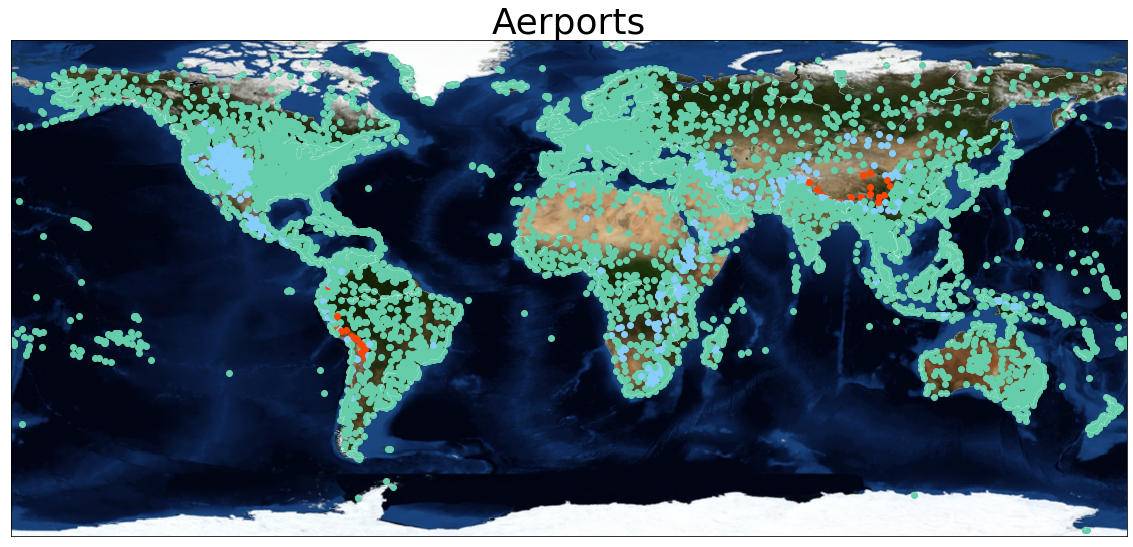

In [3]:
plt.rcParams["font.size"] = 30

fig = plt.gcf()
fig.set_size_inches(20, 20) # Veličina mape

# Biramo cilindričnu projekciju
m = Basemap(projection='cyl',    
            llcrnrlat=-80, urcrnrlat=80, \
            llcrnrlon=-180, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines

x, y = m(list(df['Longitude']),list(df['Latitude']))  # transform coordinates

colors = ['mediumaquamarine','lightskyblue','orangered'] # Aerodrome bojimo na mapi u zavisnosti od visinske kategorije
category_altitude = list(df['Altitude_CATEGORY'])

plt.title("Aerports")
for i in range(0,len(x)):
    plt.scatter(x[i],y[i], color = colors[category_altitude[i] - 1])

plt.savefig("../Visualisations/Data_on_map_with_high_categories.png")
plt.show()

## Preprocesiranje podataka
### Izdvajanje karakteristika po kojima vrsimo klasterovanje
#### (za početak ćemo vršiti klasterovanje samo po atributima 
####  *Longitude* i *Latitude*  (trenutno ćemo da zanemarimo nadmorsku visinu)

In [4]:
features = df.columns[6:8]
df[features].head()

,Latitude,Longitude
0,-6.081690,145.391998
1,-5.207080,145.789001
2,-5.826790,144.296005
3,-6.569803,146.725977
4,-9.443380,147.220001


## Preprocesiranje podataka
### Skaliranje raspona vrednosti svih atributa po kojima
### vršimo skaliranje na interval $(0,1)$

In [5]:
scaler = MinMaxScaler()
scaler.fit(df[features]) # Za svaki atribut nalazi najveću i najmanju vrednost, na osnovu njih će skalirati
x = pd.DataFrame(scaler.transform(df[features])) # Skaliranje vrednosti
x.columns = features
x.head()

,Latitude,Longitude
0,0.486433,0.903957
1,0.491502,0.905060
2,0.487910,0.900911
3,0.483603,0.907664
4,0.466947,0.909037


## Primena algoritma **DBSCAN** za različite vrednosti parametara i upoređivanje rezultata

  Dobijena vizuelizacija nam može pomoći pri proceni za odabir parametara, $\varepsilon$ i minimalnog broja suseda. Više puta ćemo pokušavati sa različitim kombinacijama. 

In [6]:
# Funkcija za opisivanje klastera
def describe_clusters(df, features ,n): # n - broj klastera
    if 'labels' not in df.columns:
        print("Ne postoji kolona sa klasterima ili se drugacije naziva")
        return
    print(" ~ Opis dobijenih klastera: ~\n\n\n")
    
    noise_cluster =  df.loc[ df['labels'] == -1]
    noise_num_of_members = len(noise_cluster)
    if noise_num_of_members != 0:
        print("********** Klaster suma (eng. Noise) : **********\n\n\n")
        print("Udeo: {} % ".format( int((noise_num_of_members/whole_set) * 100) ) )
        print(" - Deskriptivne statistike: ")
        print(noise_cluster.describe()[features])
        print("\n\n\n\n\n")
        
    for i in range(0,n):
        this_cluster = df.loc[ df['labels'] == i]
        num_of_members = len(this_cluster)
        if num_of_members == 0: # Ako se dogodi da imamo prazan klaster
            continue              # Nema potrebe ispisivati informacije o njemu
        print("********** Klaster {} : **********\n\n\n".format(i))
        print("Udeo: {} % ".format( int((num_of_members/whole_set) * 100) ) )
        print(" - Deskriptivne statistike: ")
        print(this_cluster.describe()[features])
        print("\n\n\n\n\n")

In [7]:
colors = ['red','deepskyblue','gold','lightgreen','palevioletred','purple','orangered',
          'blueviolet','darkblue','cadetblue','indigo','tomato','mediumaquamarine',
          'olive','c','maroon','darkseagreen','cornflowerblue','orchid','lightcoral',
          'lavender','slateblue','yellowgreen','forestgreen','antiquewhite', 'sienna',
          'darkcyan','deeppink','thistle','plum','powderblue','sandybrown','m',
          'chartreuse','lemonchiffon','mistyrose','darkmagenta','brown','peru',
          'chocolate','royalblue']

# Prvo ćemo napisati funkciju za treniranje modela, ispis rezultata i prikaz
# df - originalni DataFrame koji obrađujemo
# x - DataFrame sa skaliranim vrednostima i izdvojenim karakteristikama, eps i min_samples
def model_DBSCAN(df,x,eps,min_samples):
    est = DBSCAN(eps = eps,min_samples = min_samples) # Pravimo instancu modela
    est.fit(x) # Treniramo model
    
    df['labels'] = est.labels_ # Dodeljujemo dobijene klastere
    
    senka_koeficijent = silhouette_score(x, est.labels_)
    # Ispisujemo kvalitet klasterovanja
    print("** Dobijeni senka koeficijent je {} ".format(senka_koeficijent))
    if senka_koeficijent <= 0.0:
        print("-- Los kvalitet klasterovanja (POOR)")
    
    elif senka_koeficijent <= 0.5:
        print("-- Nije dobar kvalitet klasterovanja (FAIR)")
    
    elif senka_koeficijent < 0.7:
        print("-- Dobar kvalitet klasterovanja (GOOD)")
        
    else:
        print("-- Najbolji kvalitet klasterovanja, klasteri su gusti i dobro grupisani (GOOD)")
    
    num_of_clusters = max(df['labels']) + 1
    describe_clusters(df=df,n=num_of_clusters, features = features)
    
    # Iscrtavamo klastere na mapi
    
    figure = plt.figure(figsize= (20,9.5))
    for i in range(-1,num_of_clusters):
        
        if i == -1: # Da li trenutno crtamo šum
            label = "noise"
            color = "lightgray"
        else:
            label = "cluster %d"%i
            color = colors[i]
        
        # Elementi koji pripadaju klasteru koji trenutno crtamo
        current_cluster = df[df['labels'] == i]
        plt.scatter(current_cluster['Longitude'], current_cluster['Latitude'], 
                   color = color, label = label)
    plt.legend()
    plt.show()
    

** Dobijeni senka koeficijent je 0.3035633226464082 
-- Nije dobar kvalitet klasterovanja (FAIR)
 ~ Opis dobijenih klastera: ~



********** Klaster suma (eng. Noise) : **********



Udeo: 7 % 
 - Deskriptivne statistike: 
         Latitude   Longitude
count  536.000000  536.000000
mean    18.773204   32.891100
std     44.097796  123.558714
min    -90.000000 -179.876999
25%    -17.353275  -68.663302
50%     19.501750   73.240501
75%     62.095846  163.658993
max     82.517799  179.951004






********** Klaster 0 : **********



Udeo: 46 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  3539.000000  3539.000000
mean     30.961763    58.658619
std      25.324514    53.093508
min     -42.836102   -27.090799
25%      21.261401    10.018134
50%      37.445663    41.019402
75%      49.567084   111.195390
max      77.896944   174.365005






********** Klaster 1 : **********



Udeo: 38 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  2889.000000 

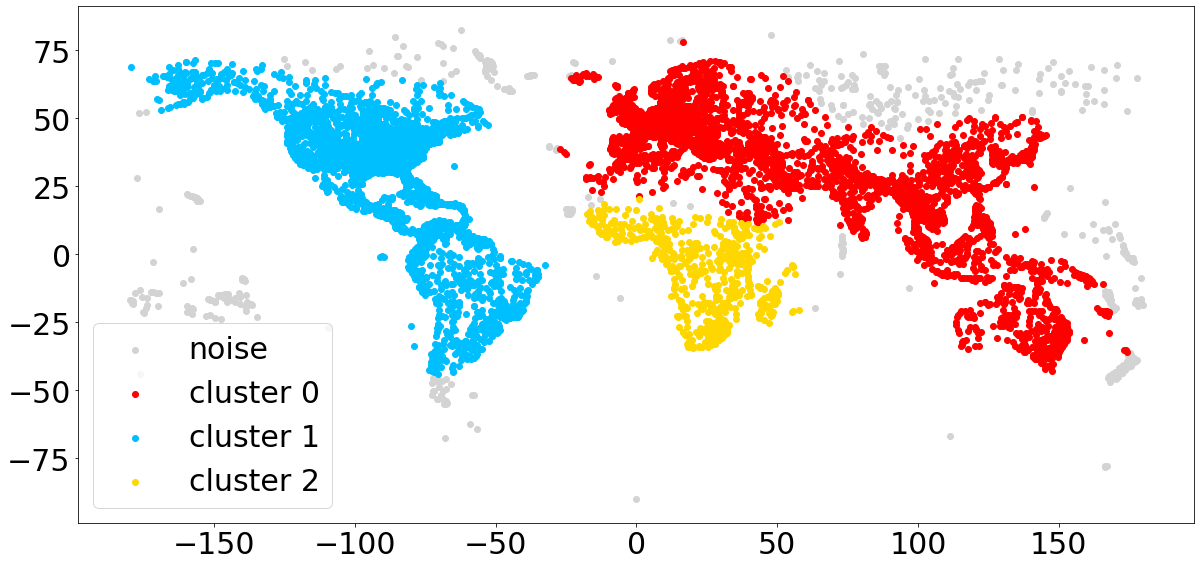

In [8]:
# Prva procena: eps = 0.05 , minimalan broj suseda = 100

model_DBSCAN(df = df,x = x,eps = 0.05, min_samples= 100)

### Analiza dosadašnjih rezultata i procene za dalje pokušaje

  Rezultat nije dobar kao sto smo očekivali. Veliki broj elemenata je proglašen šumom. S druge strane, klasteri nisu ni previše gusti.
  
  Na ovoj slici vidimo i problem sa našim podacima. U Evropi, Severnoj Americi, po obodima Južne Amerike i Afrike je prilično velika gustina aerodroma. Za razliku od tih delova sveta, u većem delu Azije nema toliko gustih delova koji bi obuhvatili ostale aerodrome u svoj klaster.
  
  **Novi pokušaj:** Ostavićemo trenutno isto $\varepsilon$, a pokušaćemo sa manjim brojem
  minimalnog broja suseda.

** Dobijeni senka koeficijent je 0.3047665141784435 
-- Nije dobar kvalitet klasterovanja (FAIR)


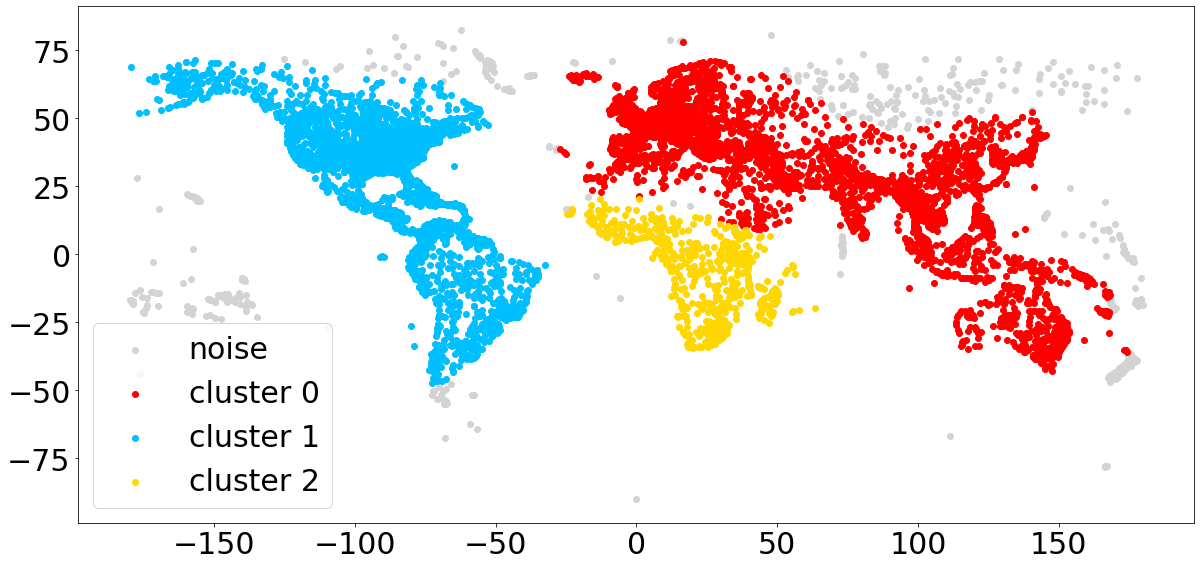

In [37]:
# Nova procena: eps = 0.05, minimalan broj suseda = 90

model_DBSCAN(df = df, x = x, eps = 0.05, min_samples = 88)

** Dobijeni senka koeficijent je 0.3939959125988138 
-- Nije dobar kvalitet klasterovanja (FAIR)


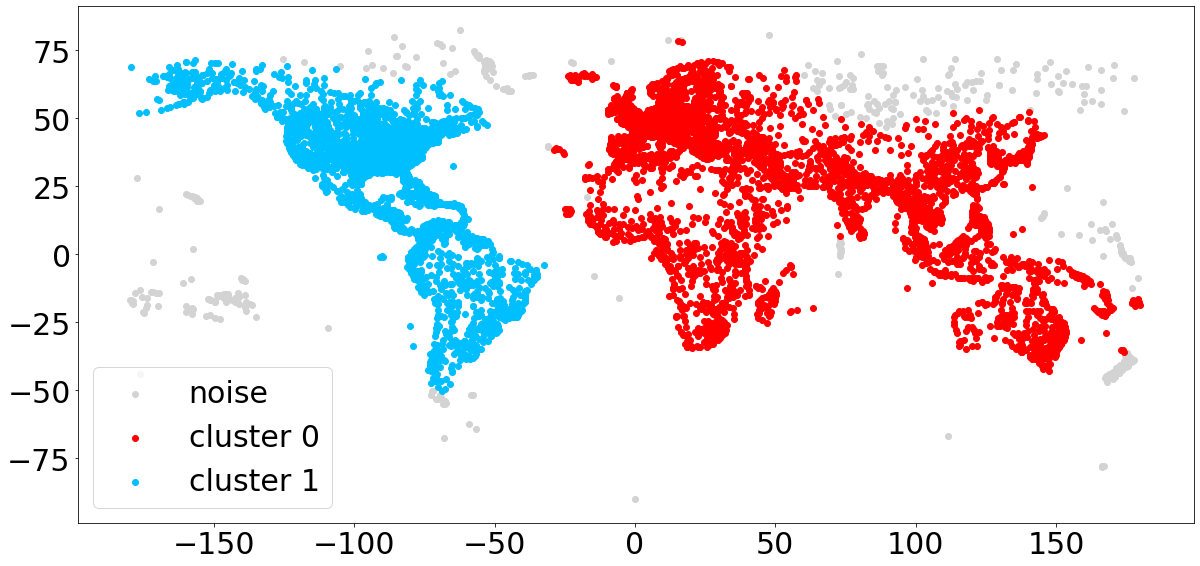

In [38]:
# Skoro sve tačke su ostale šum.
# Smanjujemo dalje minimalan_broj_suseda za isto epsilon
# Nova procena: eps = 0.1, minimalan_broj_suseda = 100

model_DBSCAN(df = df, x = x, eps = 0.05, min_samples = 80)

** Dobijeni senka koeficijent je 0.4001527691078875 
-- Nije dobar kvalitet klasterovanja (FAIR)


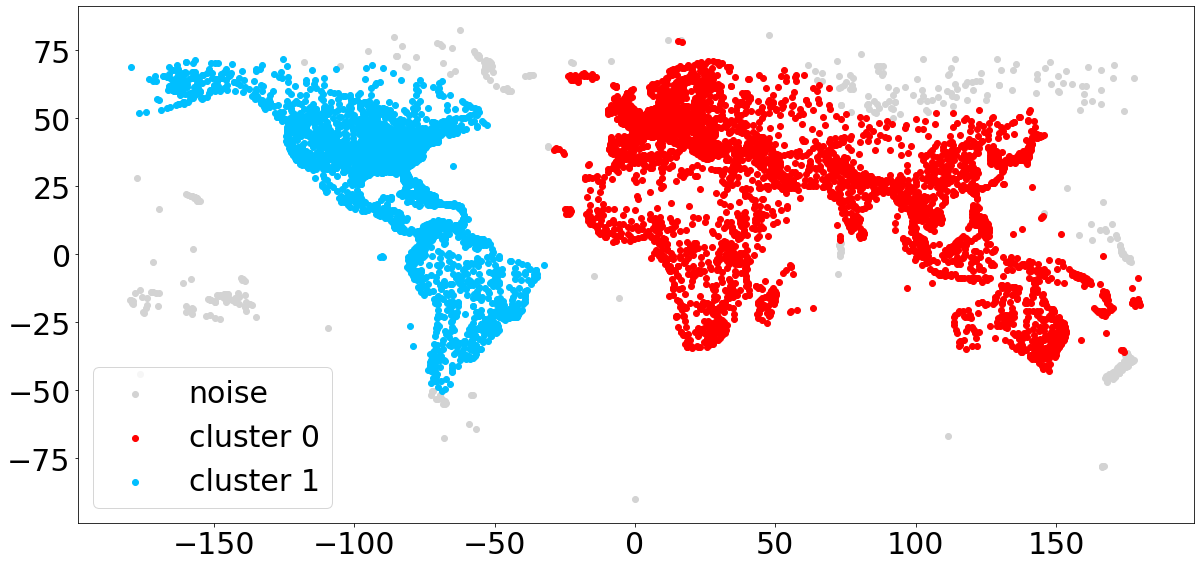

In [39]:
# Možemo da primetimo nezanemarljivo povećanje senka-koeficijenta.
# Na osnovu te mere nam je klasterovanje nesto bolje, ali opet nije blizu dobrog.

# Minimalan broj suseda je bio dovoljno mali da neki granični elementi postanu elementi
# jezgra i time se dva klastera (aerodroma iz Afrike i Evrope) spoje u jedan, ali opet ne dovoljno mali da bi neki element
# sa severa Azije postao element jezgra.
# Svejedno, još ćemo smanjivati minimalan_broj_suseda da vidimo šta će dalje da se menja.

model_DBSCAN(df = df, x = x, eps = 0.05, min_samples = 68)

** Dobijeni senka koeficijent je 0.40761719973062494 
-- Nije dobar kvalitet klasterovanja (FAIR)


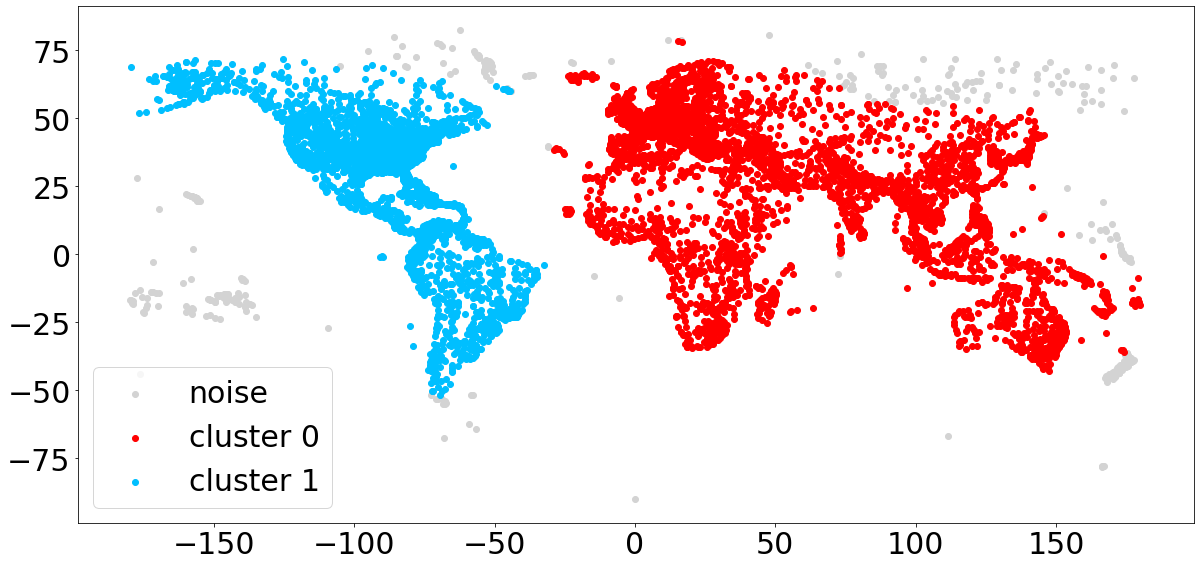

In [40]:
# Samo neznatno raste senka koeficijent.
model_DBSCAN(df = df, x = x, eps = 0.05, min_samples = 59)

** Dobijeni senka koeficijent je 0.33798230395549983 
-- Nije dobar kvalitet klasterovanja (FAIR)


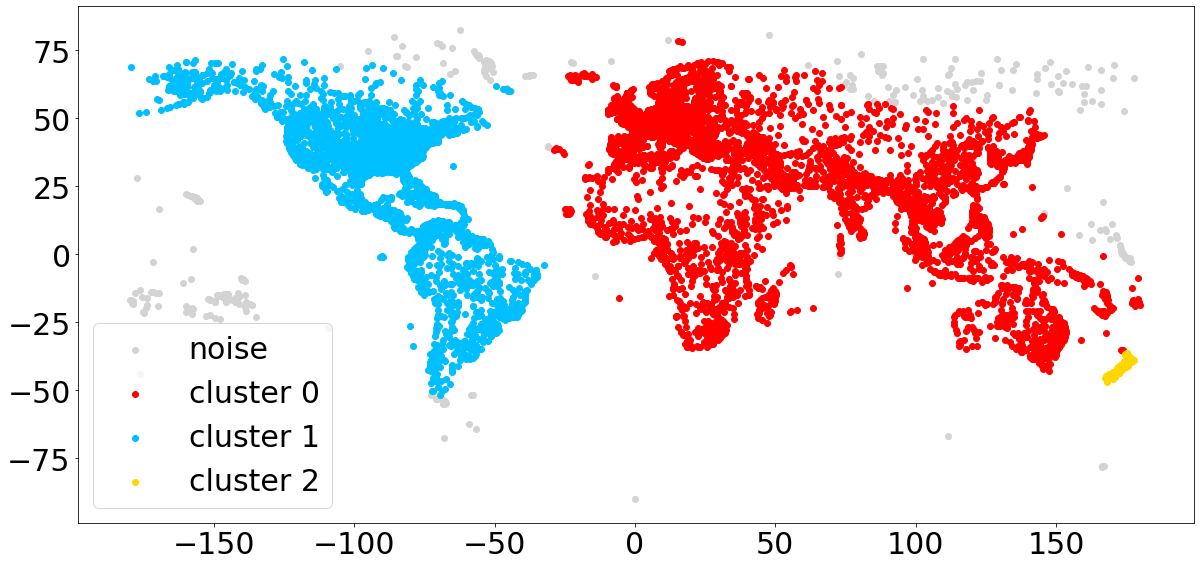

In [41]:
model_DBSCAN(df = df, x = x, eps = 0.05, min_samples = 58)

### Analiza dosadasnjih rezultata i procene za dalje pokusaje

  U pretposlednja 2 pokusaja smo postigli najveci senka koeficijent i tu smo obuhvatili najveći broj elemenata koji su prethodno bili šum. U poslednjem pokušaju, gde je broj suseda bio smanjen za 1 u odnosu na prethodni je obuhvaćeno najviše elemenata i nastao je još jedan klaster. On je mnogo manji od ostalih i znatno je gušći (u odnosu na srednje gustine ostalih).
  
  Nažalost i najveća dobijena vrednost senka koeficijenta i dalje se ne graniči sa dobrim klasterovanjem. 
  
  Sledeće što možemo da pokušamo je da smanjimo i $\varepsilon$ i broj suseda.

In [ ]:
model_DBSCAN(df = df, x = x, eps = 0.045,min_samples = 80)

In [ ]:
model_DBSCAN(df = df, x = x, eps = 0.045,min_samples = 60)

In [ ]:
model_DBSCAN(df = df,x = x,eps = 0.02, min_samples = 25)

In [ ]:
# Nijednom nismo dobili bolje rezultate. Izvešćemo jos jedan pokušaj, sa većim epsilon.

model_DBSCAN(df = df,x = x,eps = 0.07, min_samples = 90)

## Zaključak: 
Jasno je da zbog različite gustine podataka ne možemo dobiti bolje klasterovanje primenom ovog algoritma. Iako smo samo probali sa izdvojenim 'Alitude', 'Latitude' i 'Longitude', jasno je da zbog istog problema ne bi bio bolji rezultat ni sa izdvojenim samo atributima 'Latitude' i 'Longitude', ni sa pristupom 'Longitude', 'Latitude' i 'Altitude_CATEGORY'. Ostavićemo primere i sa druga dva pristupa.

Pre nego što pokusamo sa izvršavanjem algoritma, moramo da preprocesiramo kategorički atribut 'Altitude_CATEGORY'. Imamo 3 kategorije i za svaku od njih pravimo jedan binarni atribut. Instanca neće imati 0 za tacno jedan atribut, koji odgovara vrednosti  atributa 'Altitude_CATEGORY'. Zbog računanja Euklidskog rastojanja i jednakog uticaja, umesto jedinice koristimo vrednost $\sqrt{\frac{1}{2}}$ .

In [18]:
features = ['Longitude','Latitude'] # Izdvajamo i skaliramo vrednosti atributa Longitude i Latitude
x = df[features]
scaler = MinMaxScaler().fit(x)
x = pd.DataFrame(scaler.transform(x))
x.columns = features

x['Altitude_CATEGORY'] = df['Altitude_CATEGORY']
#x = deepcopy( df[features] )

x['CAT_1'] = 0.0   # Nova binarna 3 atributa koji će odgovarati svakoj od mogućih kategorija
x['CAT_2'] = 0.0
x['CAT_3'] = 0.0
fixed_value = math.sqrt(0.5) # Ne-nula vrednost za atribute

for i in range(1,4):  # Zamenjujemo nule na odgovarajućim vrednostima
    x.loc[x['Altitude_CATEGORY'] == i, 'CAT_%d'%i] = fixed_value

x.head()

,Longitude,Latitude,Altitude_CATEGORY,CAT_1,CAT_2,CAT_3
0,0.903957,0.486433,2,0.000000,0.707107,0.0
1,0.905060,0.491502,1,0.707107,0.000000,0.0
2,0.900911,0.487910,2,0.000000,0.707107,0.0
3,0.907664,0.483603,1,0.707107,0.000000,0.0
4,0.909037,0.466947,1,0.707107,0.000000,0.0


In [19]:
# Sada još da uklonimo atribut Altitude_CATEGORY
features = ['Latitude','Longitude','CAT_1','CAT_2','CAT_3']
x = x[features]
x.head()

,Latitude,Longitude,CAT_1,CAT_2,CAT_3
0,0.486433,0.903957,0.000000,0.707107,0.0
1,0.491502,0.905060,0.707107,0.000000,0.0
2,0.487910,0.900911,0.000000,0.707107,0.0
3,0.483603,0.907664,0.707107,0.000000,0.0
4,0.466947,0.909037,0.707107,0.000000,0.0


** Dobijeni senka koeficijent je 0.2615997908493082 
-- Nije dobar kvalitet klasterovanja (FAIR)


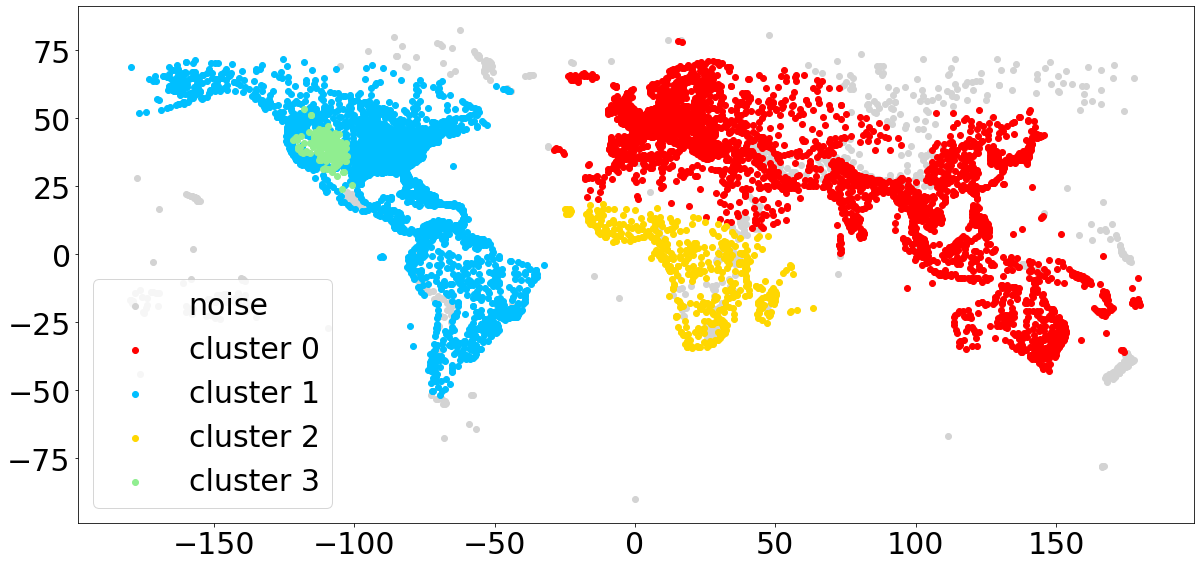

In [20]:
# Jedan od pokušaja
model_DBSCAN(df = df, x = x, eps = 0.05, min_samples = 59)

** Dobijeni senka koeficijent je 0.41025461613339476 
-- Nije dobar kvalitet klasterovanja (FAIR)


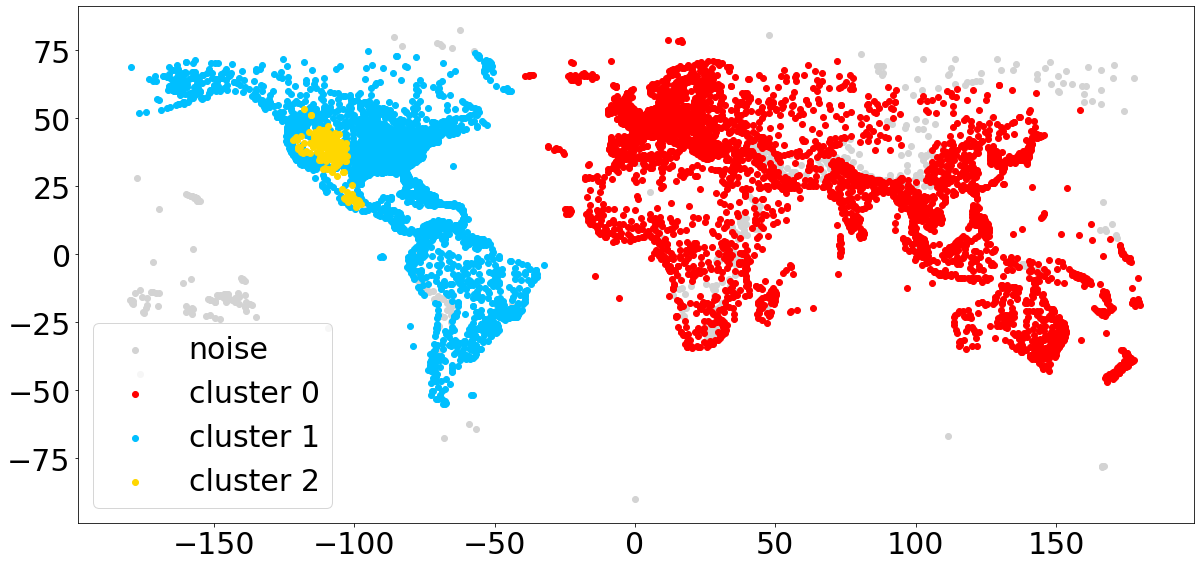

In [21]:
model_DBSCAN(df = df,x = x,eps = 0.07, min_samples = 90)

** Dobijeni senka koeficijent je 0.10855969007149902 
-- Nije dobar kvalitet klasterovanja (FAIR)


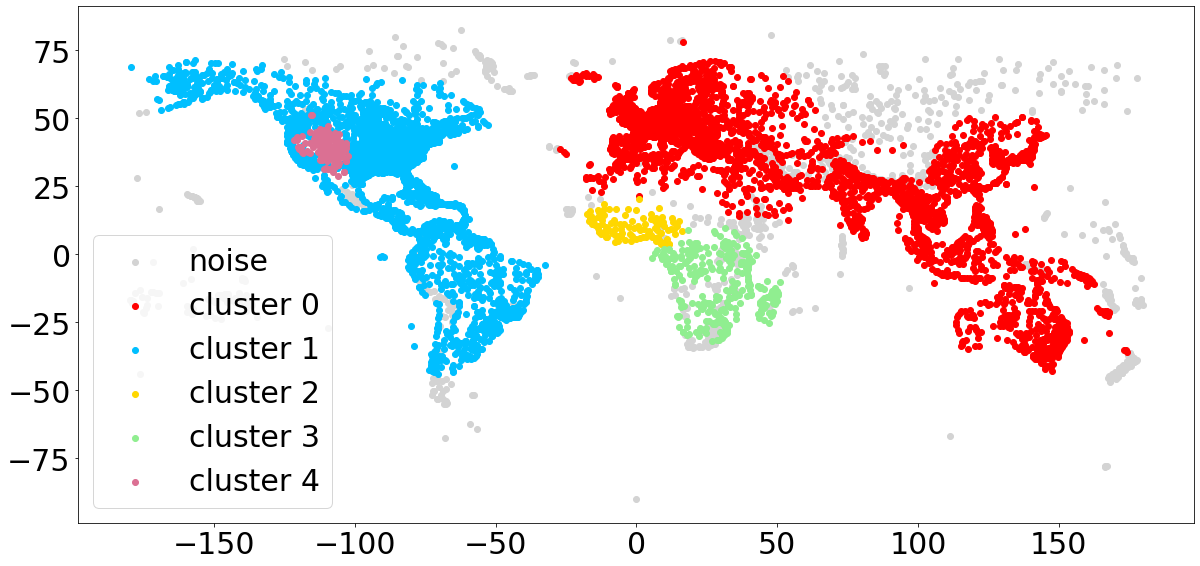

In [22]:
model_DBSCAN(df = df,x = x,eps = 0.05, min_samples= 100)

In [ ]:
# Klasterovanje na osnovu samo atributa Latitude i Longitude
x = x[['Longitude','Latitude']]
model_DBSCAN(df = df,x = x,eps = 0.07, min_samples = 90)